In [1]:
import pickle 
pickle_off = open("X_spec.pickle", 'rb')
X_spec = pickle.load(pickle_off)

pickle_off = open("y_spec.pickle", 'rb')
y_spec = pickle.load(pickle_off)

In [2]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from IPython import display
import tensorflow as tf

In [3]:
!pip install librosa

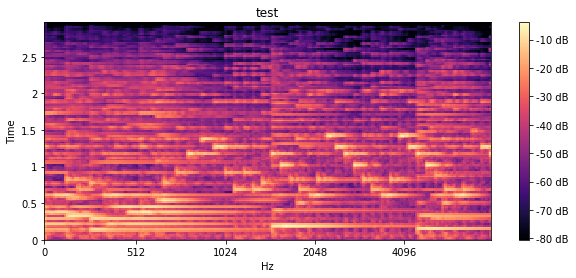

In [6]:
genre_name = 'test'
plt.figure(figsize=(10, 4))
librosa.display.specshow(X_spec[5,:256,:].T, y_axis='time', fmax=8000, x_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(str(genre_name))
plt.show()

In [4]:
#Normalize

X_spect = (X_spec.astype('float32') + 100) /116
y_spect = (y_spec.astype('float32') + 100) /116

In [5]:
# train and split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_spect, y_spect, test_size=0.1, random_state=42)

In [6]:
import numpy as np

print(X_train.shape)
print(X_test.shape)
train = np.array([X_train[:256,:,:], y_train[:256,:,:]])
test = np.array([X_test[:20,:,:], y_test[:20,:,:]])
print(train.shape)
print(test.shape)
train = train.reshape(2,256,300,128,1)
test = test.reshape(2,20,300,128,1)
print(train.shape)
print(test.shape)

(1287, 300, 128)
(144, 300, 128)
(2, 256, 300, 128)
(2, 20, 300, 128)
(2, 256, 300, 128, 1)
(2, 20, 300, 128, 1)


In [7]:
train_size = 1287
batch_size = 32
test_size = 144

#train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 #.shuffle(train_size).batch(batch_size))
train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 .batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test)
                .batch(batch_size))

In [8]:
def normalize_test(input_image, input_mask):
    input_image = input_image[:,:256,:,:]
    input_mask = input_mask[:,:256,:,:]
    input_image = tf.image.grayscale_to_rgb(input_image)  
    input_mask = tf.image.grayscale_to_rgb(input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image, input_mask = normalize_test(datapoint[0], datapoint[1])
    return input_image, input_mask

train_dataset = train_dataset.map(load_image_test)

In [9]:
def normalize_test(input_image, input_mask):
    input_image = input_image[:,:256,:,:]
    input_mask = input_mask[:,:256,:,:]
    input_image = tf.image.grayscale_to_rgb(input_image)  
    input_mask = tf.image.grayscale_to_rgb(input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image, input_mask = normalize_test(datapoint[0], datapoint[1])
    return input_image, input_mask

test_dataset = test_dataset.map(load_image_test)

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [11]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [12]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 128, 3])

  down_stack = [
    downsample(32, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
    downsample(64, 4),  # (bs, 64, 64, 128)
    #downsample(64, 4),  # (bs, 32, 32, 256)
    #downsample(128, 4),  # (bs, 16, 16, 512)
    downsample(128, 4),  # (bs, 8, 8, 512)
    #downsample(128, 4),  # (bs, 4, 4, 512)
    #downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(128, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(128, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    #upsample(128, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(128, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
    #upsample(128, 4),  # (bs, 16, 16, 1024)
    upsample(64, 4),  # (bs, 32, 32, 512)
    #upsample(64, 4),  # (bs, 64, 64, 256)
    upsample(32, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
generator = Generator()

In [14]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [15]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 128, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [16]:
discriminator = Discriminator()


In [17]:
import matplotlib.pyplot as plt


for i in test_dataset.take(1):
  j = np.array(i) 
  one = (j[0,1,:,:,1] * 116) -100
  print(one.shape)

  genre_name = 'real'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(one.T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()

  gen_output = generator(j[0,:1,:256,:,:], training=False)
  print(gen_output.shape)
  tt = (gen_output[:,:,:,1] * 116 ) -100
  print(tt.shape)

  tt = np.array(tt).reshape(256,128)
  genre_name = 'gen'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(tt.T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()
  #plt.imshow(gen_output[0, ...])

  break


KeyboardInterrupt: 

In [18]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [19]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [39]:
def generate_images(model, test_input, tar, num):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(12, 6))
  num=num
  inp = (np.array(test_input[num,:,:,1]).reshape(256,128) * 116) -100
  truth = (np.array(tar[num,:,:,1]).reshape(256,128) * 116) -100
  pred = (np.array(prediction[num,:,:,1]).reshape(256,128) * 116) -100

  print(len(np.unique(inp)), len(np.unique(truth)), len(np.unique(pred)))
  display_list = [inp, truth, pred]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    librosa.display.specshow(display_list[i].T, y_axis='time', fmax=8000, x_axis='mel')
    plt.colorbar(format='%+2.0f dB')

    #plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [21]:
EPOCHS = 10

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))



In [22]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [23]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 20 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 40

fit(train_dataset, EPOCHS, test_dataset)

32249 32165 32648


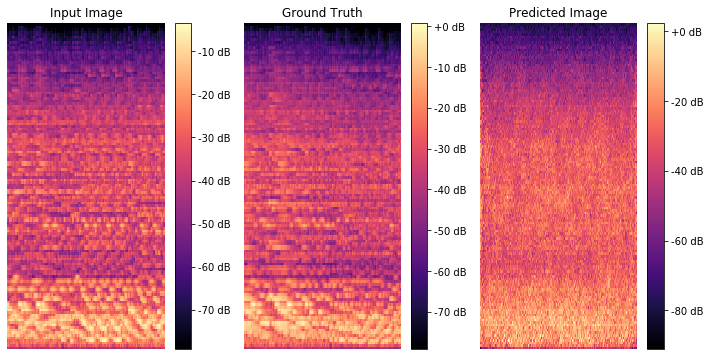

In [51]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target, 4)


In [36]:
import scipy
from scipy.io.wavfile import write
import numpy as np

for example_input, example_target in test_dataset.take(1):

    prediction = generator(example_input, training=True)
    plt.figure(figsize=(12, 6))
    num=3
    pred = (np.array(prediction[num,:,:,1]).reshape(256,128) * 116) -100
    test = (np.array(example_target[num,:,:,1]).reshape(256,128) * 116) -100


    sr=22050
   # t = X_spec[5,:256,:]
    audio_path = 'pred3.wav'
    wav = librosa.db_to_power(pred.T, ref=1.0)
    wav = librosa.feature.inverse.mel_to_audio (M=wav, hop_length=512, sr=sr)
    wav *= 32767 / max (0.01, np.max(np.abs(wav)))
    write (audio_path, sr, wav.astype(np.int16))
    #write (audio_path, sr, wav.astype(np.float32))
    
    audio_path = 'test3.wav'
    wav = librosa.db_to_power(test.T, ref=1.0)
    wav = librosa.feature.inverse.mel_to_audio (M=wav, hop_length=512, sr=sr)
    wav *= 32767 / max (0.01, np.max(np.abs(wav)))
    write (audio_path, sr, wav.astype(np.int16))
    #write (audio_path, sr, wav.astype(np.float32))

<Figure size 864x432 with 0 Axes>

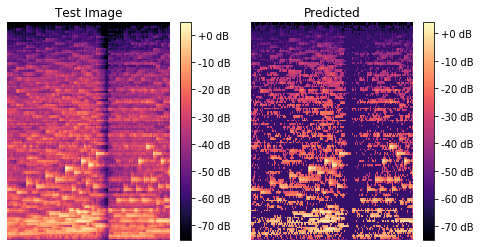

In [76]:

final = np.full((256, 128), -60)
for example_input, example_target in test_dataset.take(1):

    prediction = generator(example_input, training=True)
    plt.figure(figsize=(8, 4))
    num=2
    pred = (np.array(prediction[num,:,:,1]).reshape(256,128) * 116) -100
    test = (np.array(example_target[num,:,:,1]).reshape(256,128) * 116) -100
    

    for i in range(0, pred.shape[0]):
        for j in range(0, pred.shape[1]):
            if test.item(i, j) >= pred.item(i, j):
                final[i,j] = test.item(i, j)
            else:
                continue
                

    display_list = [test, final]
    title = ['Test Image', 'Predicted']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        librosa.display.specshow(display_list[i].T, y_axis='time', fmax=8000, x_axis='mel')
        plt.colorbar(format='%+2.0f dB')

        #plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    break



sr=22050
# t = X_spec[5,:256,:]
audio_path = 'fin5.wav'
wav = librosa.db_to_power(final.T, ref=1.0)
wav = librosa.feature.inverse.mel_to_audio (M=wav, hop_length=512, sr=sr)
wav *= 32767 / max (0.01, np.max(np.abs(wav)))
write (audio_path, sr, wav.astype(np.int16))

audio_path = 'test5.wav'
wav = librosa.db_to_power(test.T, ref=1.0)
wav = librosa.feature.inverse.mel_to_audio (M=wav, hop_length=512, sr=sr)
wav *= 32767 / max (0.01, np.max(np.abs(wav)))
write (audio_path, sr, wav.astype(np.int16))




In [66]:
np.full((2,3), 10)

array([[10, 10, 10],
       [10, 10, 10]])